# **SpamClassifier**

# Обучаем LSTM на классификацию спама на английском

In [100]:
import pandas as pd
import numpy as np

df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Последние 3 столбца - куча всякого мусора, поэтому оставим только столбцы v1 и v2.

In [101]:
df = df[['v1', 'v2']]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [72]:
target = 'v1'
feature = 'v2'

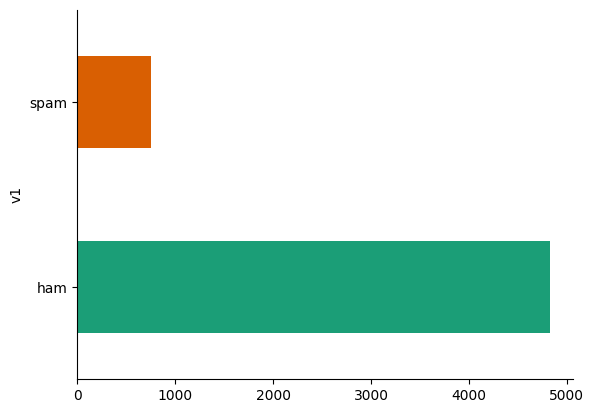

In [ ]:
# @title Распределение спама и не спама

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('v1').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [102]:
# Warning! Don't run this cell twice!
df[target] = df[target].apply(lambda x: 1 if x == 'spam' else 0)
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Посчитаем максимальную длину текста в описании.

In [74]:
max_words = 0
for desc in df[feature]:
  words = len(desc.split())
  if words > max_words:
    max_words = words

f'Max message body length: {max_words} words'

'Max message body length: 171 words'

Проведём обработку текстов сообщений.<p/>
Заменим все почтовые адреса на emailaddress. В данной задаче мы никак не можем проверить, что это за адрес, поэтому будем просто их заменять одним словом, означающим, что это почтовый адрес. <p/>
Аналогично поступим со ссылками. Ссылки с http будем заменять на insecurehttpaddress, с https заменим на httpaddress. Разделение нужно потому, что если в сообщении содержится ссылка на ресурс без TLS, то, вероятнее всего, это спам.<p/>
Также стоит заменить телефонные номера и наборы чисел на соответствующие слова.<p/>
Будет не лишним привести слова к одному виду (стемминг) с помощью PorterStemmer, а также убрать слова, не несущие никакой информации (стоп-слова).

In [103]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

ps = PorterStemmer()

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

for i in range(len(df)):
  msg = df[feature][i]
  msg = re.sub('\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddress', msg) # email
  msg = re.sub('(http\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'insecurehttpaddress', msg) # http url
  msg = re.sub('(https\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddress', msg) # https url
  msg = re.sub('€|¥|£|\$', 'moneysmbl', msg) # money
  msg = re.sub('\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenmbr', msg) # phone number
  msg = re.sub('\d+(\.\d+)?', 'nmbr', msg) # number

  msg = re.sub('[^\w\d\s]', ' ', msg) # punctiation
  msg = msg.lower() # to lowercase
  msg = re.sub(' +', ' ', msg) # remove multiple spaces

  words = msg.split()
  words = [ps.stem(word) for word in words if word not in stopwords]

  df.at[i, feature] = ' '.join(words)

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,v1,v2
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri nmbr wkli comp win fa cup final tkt...
3,0,u dun say earli hor u c alreadi say
4,0,nah think goe usf live around though


Следущий шаг - преобразование набора слов в набор чисел. Для этого используем TfidfVectorizer. Можно было бы использовать bag-of-words (CountVectorizer), которым можно посчитать, как часто каждое слово встречается в тексте, но есть существенный недостаток. Если слово встречается 5 раз в конкретном документе, но и в других документах тоже встречается часто, то его наличие в документе не особо-то о чём-то говорит. Если же слово 5 раз встречается в конкретном документе, но в других документах встречается редко, то его наличие (да ещё и многократное) позволяет хорошо отличать этот документ от других. Однако с точки зрения bag-of-words различий не будет: в обеих ячейках будет просто число 5.

Отчасти это решается исключением стоп-слов (и слишком часто встречающихся слов), но лишь отчасти. Другой идеей является отмасштабировать получившуюся таблицу с учётом "редкости" слова в наборе документов (т.е. с учётом информативности слова).

\begin{equation*}
tfidf = tf * idf \\ idf = log \frac {N + 1}{N_w + 1} + 1
\end{equation*}

tf это частота слова в тексте, N - общее число документов, Nw - число документов, содержащих данное слово.

In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer()
x = cv.fit_transform(df[feature]).toarray()
y = df[target].values

array([0, 0, 1, ..., 0, 0, 0])

Данные подготовили, теперь можем обучаться на них. Сначала разобьём выборку на тренировочную и тестовую.

In [124]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.20, random_state = 42)

Попробуем обучить модель градиентного бустинга. Будем использовать catboost.

In [113]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.7 MB/s eta 0:00:00


In [125]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    n_estimators=200,
    random_state=54
)
model.fit(
    x_train,
    y_train,
    verbose=1,
)

Learning rate set to 0.085316
0:	learn: 0.5735349	total: 49.4ms	remaining: 9.84s
1:	learn: 0.4738805	total: 87.7ms	remaining: 8.68s
2:	learn: 0.4102959	total: 129ms	remaining: 8.45s
3:	learn: 0.3640301	total: 170ms	remaining: 8.35s
4:	learn: 0.3118993	total: 208ms	remaining: 8.1s
5:	learn: 0.2741422	total: 248ms	remaining: 8.03s
6:	learn: 0.2510279	total: 288ms	remaining: 7.95s
7:	learn: 0.2191974	total: 327ms	remaining: 7.85s
8:	learn: 0.2021153	total: 371ms	remaining: 7.88s
9:	learn: 0.1865883	total: 418ms	remaining: 7.94s
10:	learn: 0.1766553	total: 461ms	remaining: 7.93s
11:	learn: 0.1663927	total: 504ms	remaining: 7.9s
12:	learn: 0.1555882	total: 551ms	remaining: 7.93s
13:	learn: 0.1478079	total: 591ms	remaining: 7.85s
14:	learn: 0.1423514	total: 630ms	remaining: 7.77s
15:	learn: 0.1345563	total: 671ms	remaining: 7.72s
16:	learn: 0.1297358	total: 710ms	remaining: 7.64s
17:	learn: 0.1256154	total: 750ms	remaining: 7.58s
18:	learn: 0.1194868	total: 786ms	remaining: 7.48s
19:	learn: 

Посчитаем ROC AUC score получившейся модели.

In [134]:
from sklearn.metrics import roc_auc_score, roc_curve

y_train_predicted = model.predict_proba(x_train)[:, 1]
y_test_predicted = model.predict_proba(x_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

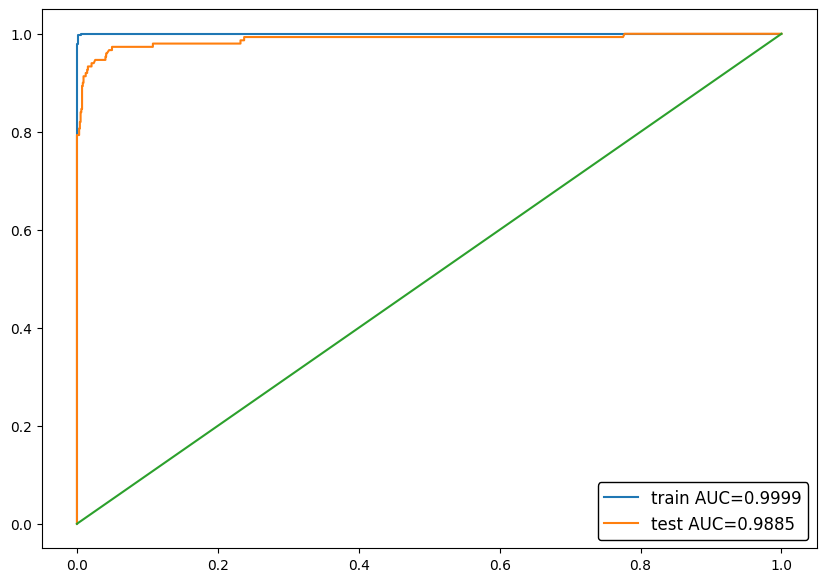

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()